<a href="https://colab.research.google.com/github/tarek-05/Gan_demo/blob/master/Copy_of_CO_Concentration_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [79]:
import pandas as pd
import geopandas as gpd

# Read the meta-data file
meta_data = pd.read_csv('/content/attributes.csv')

# Read the location data
location_data = gpd.read_file('/content/locations.geojson')

# Concatenate all the measurements files into a single data frame
years = ['2016', '2017', '2018']
measurements_data = pd.concat([pd.read_csv(f'/content/measurements-{y}.csv') for y in years])
print(location_data)

          id       lon        lat                   geometry
0   28079004 -3.712247  40.423853  POINT (-3.71225 40.42385)
1   28079008 -3.682319  40.421564  POINT (-3.68232 40.42156)
2   28079011 -3.677356  40.451475  POINT (-3.67736 40.45148)
3   28079016 -3.639233  40.440047  POINT (-3.63923 40.44005)
4   28079017 -3.713322  40.347139  POINT (-3.71332 40.34714)
5   28079018 -3.731853  40.394781  POINT (-3.73185 40.39478)
6   28079024 -3.747347  40.419356  POINT (-3.74735 40.41936)
7   28079027 -3.580031  40.476928  POINT (-3.58003 40.47693)
8   28079035 -3.703172  40.419208  POINT (-3.70317 40.41921)
9   28079036 -3.645306  40.407947  POINT (-3.64531 40.40795)
10  28079038 -3.707128  40.445544  POINT (-3.70713 40.44554)
11  28079039 -3.711542  40.478228  POINT (-3.71154 40.47823)
12  28079040 -3.651522  40.388153  POINT (-3.65152 40.38815)
13  28079047 -3.686825  40.398114  POINT (-3.68682 40.39811)
14  28079048 -3.690367  40.439897  POINT (-3.69037 40.43990)
15  28079049 -3.682583  

In [80]:
location_data=location_data.drop(['geometry'], axis=1)
location_data

,id,lon,lat
0,28079004,-3.712247,40.423853
1,28079008,-3.682319,40.421564
2,28079011,-3.677356,40.451475
3,28079016,-3.639233,40.440047
4,28079017,-3.713322,40.347139
5,28079018,-3.731853,40.394781
6,28079024,-3.747347,40.419356
7,28079027,-3.580031,40.476928
8,28079035,-3.703172,40.419208
9,28079036,-3.645306,40.407947


In [81]:
measurements_data[measurements_data['station']==28079001].head()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,station
0,01/06/2016 01:00,NaN,0.47,NaN,NaN,NaN,83.089996,120.699997,NaN,16.990000,16.889999,10.40,NaN,8.98,NaN,NaN,28079001
26,01/06/2016 02:00,NaN,0.56,NaN,NaN,NaN,86.209999,150.199997,NaN,11.720000,23.740000,13.69,NaN,10.12,NaN,NaN,28079001
52,01/06/2016 03:00,NaN,0.44,NaN,NaN,NaN,82.279999,140.500000,NaN,11.500000,21.379999,12.16,NaN,9.79,NaN,NaN,28079001
78,01/06/2016 04:00,NaN,0.30,NaN,NaN,NaN,63.790001,89.980003,NaN,19.520000,8.330000,5.69,NaN,8.26,NaN,NaN,28079001
104,01/06/2016 05:00,NaN,0.31,NaN,NaN,NaN,59.349998,100.099998,NaN,19.700001,21.520000,12.93,NaN,8.94,NaN,NaN,28079001


In [82]:
drop_cols = ['BEN', 'EBE', 'MXY', 'NMHC', 'OXY', 'PM25', 'PXY', 'TCH', 'TOL']
measurements_data.drop(columns=drop_cols, inplace=True)
measurements_data.count()
print(measurements_data.corr())

               CO      NO_2       NOx       O_3      PM10      SO_2   station
CO       1.000000  0.770636  0.894887 -0.480590  0.518167  0.608921 -0.091577
NO_2     0.770636  1.000000  0.898453 -0.591895  0.539683  0.461164 -0.131815
NOx      0.894887  0.898453  1.000000 -0.550519  0.580450  0.559924 -0.122632
O_3     -0.480590 -0.591895 -0.550519  1.000000 -0.259224 -0.367872  0.081732
PM10     0.518167  0.539683  0.580450 -0.259224  1.000000  0.295990 -0.050669
SO_2     0.608921  0.461164  0.559924 -0.367872  0.295990  1.000000 -0.083873
station -0.091577 -0.131815 -0.122632  0.081732 -0.050669 -0.083873  1.000000


In [83]:
a=measurements_data['station'].unique()
a= np.sort(a)
print(a, len(a))

[28079001 28079003 28079004 28079006 28079007 28079008 28079009 28079011
 28079012 28079014 28079015 28079016 28079017 28079018 28079019 28079021
 28079022 28079023 28079024 28079025 28079026 28079027 28079036 28079038
 28079039 28079040 28079047 28079048 28079049 28079050 28079054 28079055
 28079056 28079057 28079058 28079059 28079060 28079099] 38


In [233]:
merged_df= pd.merge(measurements_data, location_data, left_on='station', right_on='id', how='left').dropna(subset=['id'])
merged_df=merged_df.fillna(0)

In [197]:
b= np.sort(merged_df['station'].unique())
b, len(b)

(array([28079004, 28079008, 28079011, 28079016, 28079017, 28079018,
        28079024, 28079027, 28079036, 28079038, 28079039, 28079040,
        28079047, 28079048, 28079049, 28079050, 28079054, 28079055,
        28079056, 28079057, 28079058, 28079059, 28079060]), 23)

In [198]:
location_data['id']

0     28079004
1     28079008
2     28079011
3     28079016
4     28079017
5     28079018
6     28079024
7     28079027
8     28079035
9     28079036
10    28079038
11    28079039
12    28079040
13    28079047
14    28079048
15    28079049
16    28079050
17    28079054
18    28079055
19    28079056
20    28079057
21    28079058
22    28079059
23    28079060
Name: id, dtype: int64

In [199]:
merged_df[merged_df['station']==28079004]

,date,CO,NO_2,NOx,O_3,PM10,SO_2,station,id,lon,lat
2,01/06/2016 01:00,0.55,75.919998,104.599998,13.47,20.27,6.95,28079004,28079004.0,-3.712247,40.423853
28,01/06/2016 02:00,0.46,67.330002,103.699997,10.25,6.51,7.17,28079004,28079004.0,-3.712247,40.423853
54,01/06/2016 03:00,0.51,57.880001,120.099998,8.94,10.86,7.90,28079004,28079004.0,-3.712247,40.423853
80,01/06/2016 04:00,0.53,67.930000,112.099998,11.77,13.42,7.28,28079004,28079004.0,-3.712247,40.423853
106,01/06/2016 05:00,0.41,53.470001,84.339996,10.22,10.78,7.02,28079004,28079004.0,-3.712247,40.423853
...,...,...,...,...,...,...,...,...,...,...,...
651419,31/07/2018 20:00,0.26,27.480000,32.570000,NaN,NaN,6.81,28079004,28079004.0,-3.712247,40.423853
651441,31/07/2018 21:00,0.28,45.650002,52.180000,NaN,NaN,6.54,28079004,28079004.0,-3.712247,40.423853
651463,31/07/2018 22:00,0.36,60.910000,66.169998,NaN,NaN,6.35,28079004,28079004.0,-3.712247,40.423853
651485,31/07/2018 23:00,0.39,74.269997,79.430000,NaN,NaN,6.44,28079004,28079004.0,-3.712247,40.423853


In [200]:
location_data.describe()

,id,lon,lat
count,2.400000e+01,24.000000,24.000000
mean,2.807904e+07,-3.679019,40.434616
std,1.799094e+01,0.049324,0.043022
min,2.807900e+07,-3.774611,40.347139
25%,2.807902e+07,-3.711718,40.405489
50%,2.807904e+07,-3.687797,40.431875
75%,2.807905e+07,-3.649968,40.465331
max,2.807906e+07,-3.580031,40.518058


In [201]:
lon=[-3.8, -3.5]; lat=[40.3, 40.52]

In [202]:
np.arange(0, 1, 0.25)

array([0.  , 0.25, 0.5 , 0.75])

In [203]:
import tensorflow as tf 
feature_columns= []

nb_lats, nb_lon= 3,3 

min, max= location_data['lat'].min(), location_data['lat'].max()
boundaries= list(np.linspace(min, max, nb_lats))
lat= tf.feature_column.numeric_column('lat')
bucket_lat= tf.feature_column.bucketized_column(lat, boundaries=boundaries)

min, max= location_data['lon'].min(), location_data['lon'].max()
boundaries= list(np.linspace(min, max, nb_lon))
lat= tf.feature_column.numeric_column('lon')
bucket_lon= tf.feature_column.bucketized_column(lat, boundaries=boundaries)

bucket_point= tf.feature_column.crossed_column([bucket_lat, bucket_lon], hash_bucket_size=nb_lats*nb_lon)
bucket_point= tf.feature_column.indicator_column(bucket_point)
feature_columns.append(bucket_point)

CO_col= tf.feature_column.numeric_column('CO')
feature_columns.append(CO_col)

No_col= tf.feature_column.numeric_column('NO_2')
feature_columns.append(No_col)

NOx_col=tf.feature_column.numeric_column('NOx')
feature_columns.append(NOx_col)

SO_2_col=tf.feature_column.numeric_column('SO_2')
feature_columns.append(SO_2_col)

In [214]:
#location_data.drop(columns=['geometry'], inplace=True)
data= {}
for name, values in merged_df[0:391824].iteritems():
  data[name]=np.array(values)

In [215]:
data
# merged_df[0:100:10]

{'date': array(['01/06/2016 01:00', '01/06/2016 01:00', '01/06/2016 01:00', ...,
        '01/08/2018 00:00', '01/08/2018 00:00', '01/08/2018 00:00'],
       dtype=object),
 'CO': array([0.55000001, 0.36000001, 0.40000001, ..., 0.27000001,        nan,
               nan]),
 'NO_2': array([75.91999817, 61.02999878, 72.63999939, ..., 45.70999908,
        46.56000137, 46.77000046]),
 'NOx': array([104.5999985 ,  66.55999756,  91.22000122, ...,  47.40999985,
         49.04000092,  50.11999893]),
 'O_3': array([13.47000027, 23.11000061, 17.04000092, ...,         nan,
        46.25      , 77.70999908]),
 'PM10': array([20.27000046, 10.85000038, 19.94000053, ..., 51.25999832,
                nan,         nan]),
 'SO_2': array([6.94999981, 5.96000004, 6.05999994, ..., 7.26000023,        nan,
               nan]),
 'station': array([28079004, 28079039, 28079008, ..., 28079057, 28079058, 28079059]),
 'id': array([28079004., 28079039., 28079008., ..., 28079057., 28079058.,
        28079059.]),
 'l

In [234]:
feature_layer= tf.keras.layers.DenseFeatures(feature_columns)
print(feature_layer(data).numpy()[0:50])

[[5.500e-01 7.592e+01 1.046e+02 6.950e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [3.600e-01 6.103e+01 6.656e+01 5.960e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.000e-01 7.264e+01 9.122e+01 6.060e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [3.600e-01 6.815e+01 8.564e+01 7.930e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.800e-01 5.833e+01 6.477e+01 6.220e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.500e-01 6.085e+01 6.690e+01 7.060e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.300e-01 2.643e+01 3.062e+01 5.690e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [2.700e-01 3.331e+01 3.517e+01 4.970e+00 0.000e+00 0.0

In [244]:
b=feature_layer(data).numpy()
b

array([[  0.55,  75.92, 104.6 , ...,   1.  ,   0.  ,   0.  ],
       [  0.36,  61.03,  66.56, ...,   0.  ,   0.  ,   0.  ],
       [  0.4 ,  72.64,  91.22, ...,   1.  ,   0.  ,   0.  ],
       ...,
       [  0.27,  45.71,  47.41, ...,   1.  ,   0.  ,   0.  ],
       [   nan,  46.56,  49.04, ...,   0.  ,   0.  ,   0.  ],
       [   nan,  46.77,  50.12, ...,   1.  ,   0.  ,   0.  ]],
      dtype=float32)

In [243]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(b)
x = scaled_data[~np.isnan(scaled_data)]
x.shape

(4831098,)

In [219]:
features=scaled_data
target=scaled_data[:,0]

In [220]:
x_train, x_test, y_train, y_test=train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [221]:
x_train.shape

(313459, 13)

In [222]:
x_test.shape

(78365, 13)

In [230]:
win_length=720
batch_size=32
num_features=12
train_generator=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [231]:
train_generator[0]

(array([[[0.10299626, 0.1463377 , 0.05883015, ..., 1.        ,
          0.        , 0.        ],
         [0.06741574, 0.11763686, 0.03743532, ..., 0.        ,
          0.        , 0.        ],
         [0.07490637, 0.14001542, 0.05130484, ..., 1.        ,
          0.        , 0.        ],
         ...,
         [0.06741574, 0.11333848, 0.04253656, ..., 1.        ,
          0.        , 0.        ],
         [0.07490637, 0.10751735, 0.0458099 , ..., 0.        ,
          0.        , 0.        ],
         [0.05805244, 0.11852352, 0.04705287, ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.06741574, 0.11763686, 0.03743532, ..., 0.        ,
          0.        , 0.        ],
         [0.07490637, 0.14001542, 0.05130484, ..., 1.        ,
          0.        , 0.        ],
         [0.06741574, 0.13136084, 0.04816648, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.07490637, 0.10751735, 0.0458099 , ..., 0.        ,
          0.        , 0.

In [228]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [229]:
#early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanSquaredError()])

history=model.fit(train_generator, epochs=20, 
                            validation_data=test_generator,
                            shuffle=False)
                            #callbacks=[early_stopping])

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convert the date column to datetime format
measurements_data['date'] = pd.to_datetime(measurements_data['date'], format='%d/%m/%Y %H:%M')
# Set the date column as the index of the data frame
#measurements_data.set_index('date', inplace=True)
measurements_data.head()

ValueError: ignored

In [ ]:
from shapely.geometry import Point
import requests
import json
# Find the closest station to the target location
target_point = Point(-3.6907764, 40.4279425)
location_data['distance'] = location_data.distance(target_point)
closest_station = location_data.loc[location_data['distance'].idxmin()]
station_id = closest_station['id']
closest_station

<ipython-input-159-9098b47b14bf>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location_data['distance'] = location_data.distance(target_point)


id                                            28079008
lon                                          -3.682319
lat                                          40.421564
geometry    POINT (-3.68231944444444 40.4215638888889)
distance                                      0.010593
Name: 1, dtype: object

In [ ]:
from geopy.distance import geodesic
import json

# Load the GeoJSON file
with open('locations.geojson') as f:
    data = json.load(f)

# Define the target location
target_lat = 40.4279425
target_lon = -3.6907764

# Calculate the distance between the target location and each station location
distances = []
for feature in data['features']:
    lon, lat = feature['geometry']['coordinates']
    distance = geodesic((lat, lon), (target_lat, target_lon)).km
    distances.append(distance)

# Find the index of the closest station
index_of_closest_station = distances.index(min(distances))

# Get the properties of the closest station
closest_station_properties = data['features'][index_of_closest_station]['properties']
closest_station_properties

{'id': 28079008, 'lon': -3.68231944444444, 'lat': 40.4215638888889}

In [ ]:
data = pd.merge(measurements_data, location_data, how="inner", on='id')
data

,date,CO,id,lon,lat,geometry,distance
0,2016-06-01 01:00:00,0.55,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
1,2016-06-01 02:00:00,0.46,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
2,2016-06-01 03:00:00,0.51,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
3,2016-06-01 04:00:00,0.53,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
4,2016-06-01 05:00:00,0.41,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
...,...,...,...,...,...,...,...
391819,2018-07-31 20:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391820,2018-07-31 21:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391821,2018-07-31 22:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391822,2018-07-31 23:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962


In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(data.columns)

Index(['date', 'CO', 'id', 'lon', 'lat', 'geometry', 'distance'], dtype='object')


In [ ]:
data=data.dropna()
data

,date,CO,id,lon,lat,geometry,distance
0,2016-06-01 01:00:00,0.55,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
1,2016-06-01 02:00:00,0.46,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
2,2016-06-01 03:00:00,0.51,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
3,2016-06-01 04:00:00,0.53,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
4,2016-06-01 05:00:00,0.41,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
...,...,...,...,...,...,...,...
378883,2018-07-31 20:00:00,0.22,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378884,2018-07-31 21:00:00,0.37,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378885,2018-07-31 22:00:00,0.64,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378886,2018-07-31 23:00:00,1.00,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268


In [ ]:
data_filtered = data[data['id']==28079008]
data_filtered

,date,CO,id,lon,lat,geometry,distance
52512,2016-06-01 01:00:00,0.40,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52513,2016-06-01 02:00:00,0.42,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52514,2016-06-01 03:00:00,0.37,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52515,2016-06-01 04:00:00,0.32,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52516,2016-06-01 05:00:00,0.28,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
...,...,...,...,...,...,...,...
78739,2018-07-31 20:00:00,0.30,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78740,2018-07-31 21:00:00,0.32,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78741,2018-07-31 22:00:00,0.43,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78742,2018-07-31 23:00:00,0.56,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593


In [ ]:
data_filtered = data_filtered[['date', 'CO']]
data_filtered

,date,CO
52512,2016-06-01 01:00:00,0.40
52513,2016-06-01 02:00:00,0.42
52514,2016-06-01 03:00:00,0.37
52515,2016-06-01 04:00:00,0.32
52516,2016-06-01 05:00:00,0.28
...,...,...
78739,2018-07-31 20:00:00,0.30
78740,2018-07-31 21:00:00,0.32
78741,2018-07-31 22:00:00,0.43
78742,2018-07-31 23:00:00,0.56


In [ ]:
# Convert the date column to datetime format and set it as the index
data_filtered['date'] = pd.to_datetime(data_filtered['date'])
data_filtered = data_filtered.set_index('date')
#data_2 = data_filtered.resample('D').mean().interpolate(method='linear')
#data_2.index = pd.to_datetime(data_2.index)
#data_2 = data_2.interpolate(method='linear')
#data_2

<ipython-input-216-2660accf0c26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['date'] = pd.to_datetime(data_filtered['date'])


In [ ]:
# Scale the data to range between 0 and 1
scaler = MinMaxScaler()
final_data = scaler.fit_transform(data_filtered)
final_data.shape

(26092, 1)

In [ ]:
# Split the data into train and test sets
train_size = int(len(final_data) * 0.80)
train, test = final_data[:train_size], final_data[train_size:]
train.shape

(20873, 1)

In [ ]:
# Define the function to create the input and output sequences
def create_sequences(dataset, seq_length):
    X, y = [], []
    for i in range(len(dataset)-seq_length-1):
        seq = dataset[i:i+seq_length]
        X.append(seq)
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Define the sequence length and create the input and output sequences for train and test sets
seq_length = 720
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)
X_train.shape

(20152, 720, 1)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
630/630 [==============================] - 202s 321ms/step - loss: nan
Epoch 2/20
630/630 [==============================] - 207s 329ms/step - loss: nan
Epoch 3/20
630/630 [==============================] - 205s 325ms/step - loss: nan
Epoch 4/20
630/630 [==============================] - 204s 324ms/step - loss: nan
Epoch 5/20
630/630 [==============================] - 204s 324ms/step - loss: nan
Epoch 6/20
630/630 [==============================] - 215s 341ms/step - loss: nan
Epoch 7/20
124/630 [====>.........................] - ETA: 2:48 - loss: nan

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 12ms/step


In [ ]:
# Inverse transform the predictions and actual values to their original scales
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Calculate the mean absolute error (MAE) and root mean squared error (RMSE) of the predictions
mae = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('MAE:', mae)
print('RMSE:', rmse)

MAE: 0.07186890592525504
RMSE: 0.1031224106934451


In [ ]:
# Use the trained model to predict the CO concentration for the first month in January 2019
last_seq = train[-seq_length:]
pred_seq = []
for i in range(31):
    X = last_seq.reshape((1, seq_length, 1))
    y = model.predict(X, verbose=0)
    pred_seq.append(y[0])
    last_seq = np.concatenate((last_seq[1:], y), axis=None)

In [ ]:
pred_seq = scaler.inverse_transform(pred_seq)
print('Predicted CO concentrations for January 2019:', pred_seq)

Predicted CO concentrations for January 2019: [[0.37516538]
 [0.37347231]
 [0.37310899]
 [0.37298378]
 [0.37282834]
 [0.37323951]
 [0.37397276]
 [0.37467714]
 [0.37536763]
 [0.37592652]
 [0.3762828 ]
 [0.37642308]
 [0.37697389]
 [0.37778349]
 [0.3783806 ]
 [0.37873802]
 [0.37897131]
 [0.37911334]
 [0.37928261]
 [0.37993824]
 [0.38076782]
 [0.38137002]
 [0.38181266]
 [0.38227913]
 [0.3827123 ]
 [0.38287647]
 [0.38324967]
 [0.38383063]
 [0.38436917]
 [0.38473303]
 [0.3850452 ]]


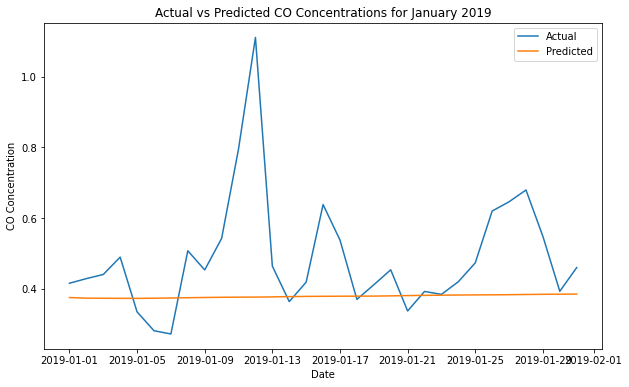

In [ ]:
import matplotlib.pyplot as plt

# Extract the actual CO concentrations for the month of January 2019 from the test set
actual_values = scaler.inverse_transform(test)
actual_values = actual_values[(len(actual_values)-31):, 0]

# Concatenate the actual and predicted values
values = np.concatenate((actual_values.reshape(-1, 1), pred_seq), axis=1)

# Create a datetime index for the values
dates = pd.date_range(start='2019-01-01', end='2019-01-31', freq='D')

# Create a dataframe with the actual and predicted values and the datetime index
df = pd.DataFrame(values, index=dates, columns=['Actual', 'Predicted'])

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Actual'], label='Actual')
plt.plot(df.index, df['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO Concentration')
plt.title('Actual vs Predicted CO Concentrations for January 2019')
plt.legend()
plt.show()